In [123]:
nSims=100
itersSim=100000
nWorkingMachines=10
nRepairmen=3
nWaitingMachines=4

In [124]:
import numpy as np
import math

distrib = np.loadtxt("E2.fallos.txt")
mu = distrib.mean()
sigmaCuad = distrib.var()
sigma = distrib.std()

x1 = (0, 0.55)
x2 = (1000, 1.65)
slope = (x2[1] - x1[1]) / (x2[0] - x1[0])
b = x1[1]*(1 - slope) # It is x[1] since l(x) = ax + b and l(0)=x[1]

# l(x) = ax + b
def ratio(x):
    return slope * x + b

def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper


In [125]:
class Machine():
    def __init__(self, broken=False, working=True):
        self.break_time = self.get_break_time(0)

    def get_break_time(self, now):
        return math.trunc(np.random.normal(mu, sigma) * 100 + now)

    def set_new_break_time(self, now):
        self.break_time = self.get_break_time(now)


class Repairman():
    def __init__(self):
        self.end_repair_time = self.get_repair_time(0)

    def get_repair_time(self, now):
        lambdaParam = ratio(now / 100)
        maq_frac_hora = np.random.exponential(1/lambdaParam) * 100
        return math.trunc(maq_frac_hora + now)

    def set_repair_time(self, now, machine):
        self.end_repair_time = self.get_repair_time(now)
        self.repairing_machine = machine

In [126]:
def simulate():
    working = [Machine() for i in range(nWorkingMachines)]
    waiting = [Machine() for i in range(nWaitingMachines)]
    repairmen = [Repairman() for i in range(nRepairmen)]
    repairmen_working  = []
    waiting_repair = []
    repairing = []
    working_time = 0
    
    for time in range(itersSim):
        for i, machine in enumerate(working):
            if machine and machine.break_time == time:
                waiting_repair.append(machine)
                try:
                    new_machine =  waiting.pop(0) # First machine in the queue
                    new_machine.set_new_break_time(time)
                    working[i] = new_machine
                except IndexError:
                    working[i] = None

        removers = []
        for i, repairman in enumerate(repairmen):
            if waiting_repair:
                machine = waiting_repair.pop(0)
                repairman.set_repair_time(time, machine)
                repairmen_working.append(repairman)
                repairing.append(machine)
                removers.append(i)
        repairmen = [rep for i, rep in enumerate(repairmen) if i not in removers]

        removers = []
        for i, repairman in enumerate(repairmen_working):
            if repairman.end_repair_time == time:
                waiting.append(repairing.pop(repairing.index(repairman.repairing_machine)))
                repairmen.append(repairman)
                removers.append(i)
        repairmen_working = [rep for i, rep in enumerate(repairmen_working) if i not in removers]

        if None in working and waiting:
            for _ in range(sum(x is None for x in working)):
                try:
                    working.append(waiting.pop(0))
                    working.remove(None)
                except IndexError:
                    break
        if None not in working:
            working_time += 1
    return working_time

In [127]:
simulate()

99138

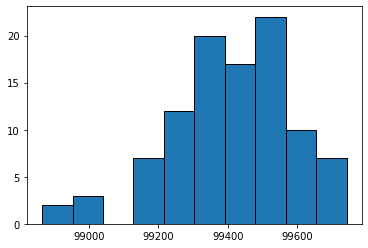

Media: 99407.37
Varianza: 30203.245555555557


In [128]:
import matplotlib.pyplot as plt
from statistics import mean, variance

simulations = [simulate() for i in range(nSims)]

plt.hist(simulations, edgecolor = 'black', linewidth=1)
plt.show()

print("Media:", mean(simulations))
print("Varianza:", variance(simulations))